In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import seaborn as sns

# Part 1 

# Duplicates, outliers and classes

In [2]:
#loading dataset
wine=pd.read_csv('winequality-red.csv')

In [3]:
#checking for null values
wine.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


<IPython.core.display.Javascript object>


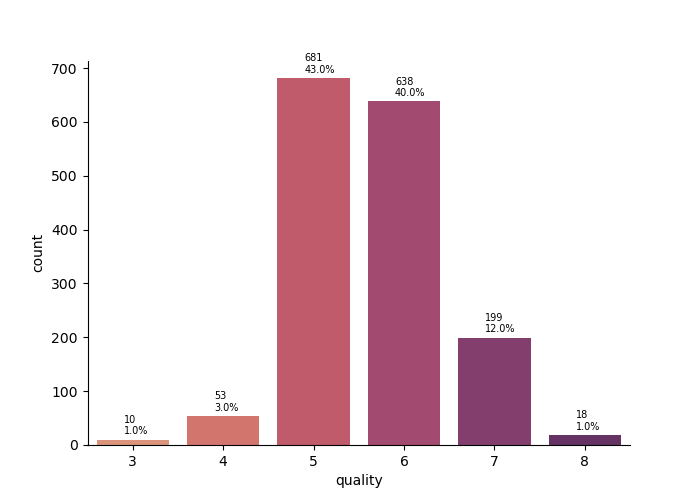

In [4]:
#checking quality column distribution
plt.figure(figsize=(7,5))
ax=sns.countplot(data=wine,x='quality',palette='flare')
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}\n{(p.get_height()/len(wine)*100).round(0)}%', (p.get_x()+0.3, p.get_height()+10), color='black', size=7)

    
ax.spines['top'].set_color('white') #setting right and top edge to invisible
ax.spines['right'].set_color('white')


plt.show()



Classes 3,4 and 8 account to only 5% of data. In this case data oversampling would not be approrpiate as majority of wines on the market are greaded as 5,6,7. Smaller number of wines are of very low or very high quality. 

I will define 2 new categories for our "quality" column. If quality > 5 then category will be "good" or 1, otherwise "average" or 0.

<IPython.core.display.Javascript object>


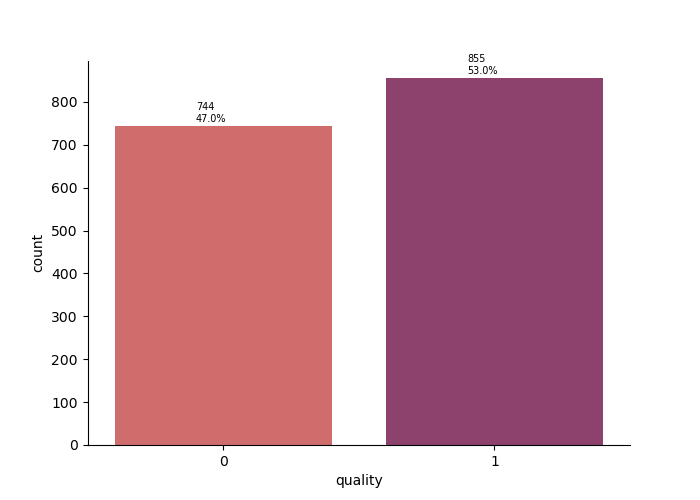

In [5]:
#redefining categories
wine['quality'].replace([3,4,5,6,7,8],[0,0,0,1,1,1],inplace=True)

#checking quality column distribution
plt.figure(figsize=(7,5))
ax=sns.countplot(data=wine,x='quality',palette='flare')
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}\n{(p.get_height()/len(wine)*100).round(0)}%', (p.get_x()+0.3, p.get_height()+10), color='black', size=7)

    
ax.spines['top'].set_color('white') #setting right and top edge to invisible
ax.spines['right'].set_color('white')


plt.show()

Now we have balanced datset and we can proceed with data cleaning.

In [6]:
sum(wine.duplicated())

240

Since there are 240 duplicatred entries we will remove them as they may cause model overfitting. 

In [7]:
wine[wine.duplicated()]['quality'].value_counts()

1    136
0    104
Name: quality, dtype: int64

Duplicates are evenly distributed between both classes so I can remove them

In [8]:
wine.drop_duplicates(inplace=True)

In [9]:
X = wine.iloc[:, 0:11].values
y = wine.iloc[:, -1].values
print(f'Number of data before removing outliers is {X.shape}')

#cleaning outliers
from sklearn.neighbors import LocalOutlierFactor
lof = LocalOutlierFactor()
yhat = lof.fit_predict(X)
# select all rows that are not outliers
mask = yhat != -1
X,y = X[mask, :], y[mask]
# summarize the shape of the updated dataset
print(f'Number of data after removing outliers is {X.shape}');

Number of data before removing outliers is (1359, 11)
Number of data after removing outliers is (1335, 11)


# Part 2 

# Feature selection 

<IPython.core.display.Javascript object>


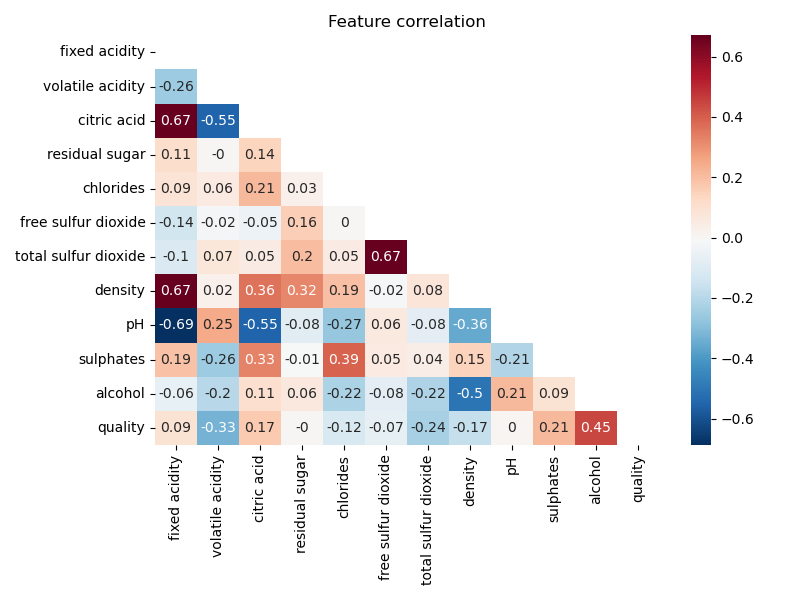

In [10]:
plt.figure(figsize=(8,6))
plt.title('Feature correlation')
shape=np.triu(wine.corr())
sns.heatmap(wine.corr(),annot=wine.corr().round(2),mask=shape,cmap='RdBu_r')
plt.tight_layout()
plt.show()

In [11]:
#splitting inot train and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [12]:
#scaling the data before feature selection
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

I will eliminate 6 variables : fixed acidity, citric acid,residual sugar, chlorides,free sulfur, pH .These were values that had highest correlation with other features or the lowest correlation with the wine quality.

In [13]:
wine.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [14]:
#defining new train set
X_train_2=X_train[:,[1,6,7,9,10]]
X_test_2=X_test[:,[1,6,7,9,10]]

# Part 3 
# Building classification models and tuning hyperparameters

I will first try Naive Bayes

In [15]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,roc_auc_score
nb_class=GaussianNB()
nb_class.fit(X_train_2,y_train)

y_pred_nb=nb_class.predict(X_test_2)
y_pred_prob_nb=nb_class.predict_proba(X_test_2)[:,1]

from sklearn.metrics import precision_recall_fscore_support
import warnings
warnings.filterwarnings('ignore')
p, r, f, s = precision_recall_fscore_support(
    y_test,
    y_pred_nb,
    labels=[0,1], # the labels for which we want the metrics determined
    average=None, # when None, returns a metric per label
)
results_nb=pd.DataFrame(data=[p.round(2),r.round(2),f.round(2),s],
                         index=[['Precision','Recall','f score','Support']],
                         columns=[['class 0','class 1']])

Naive Bayes gave pretty good results. Let's check others

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score,GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [17]:
#cross validation score is telling me that there could be some imporvement so I will proceed with the grid search. 


log_class = LogisticRegression(random_state = 0,max_iter=500)

lr_grid=GridSearchCV(estimator=log_class,
                      param_grid={'penalty' : ['l1', 'l2'],'C' : np.logspace(-4, 4, 20),
                                  'solver' : ['newton-cg','lbfgs']},
                     cv=5,verbose=0, n_jobs=-1)
lr_grid.fit(X_train_2,y_train)

lr_grid.best_params_

{'C': 0.08858667904100823, 'penalty': 'l2', 'solver': 'newton-cg'}

In [18]:
log_class = LogisticRegression(C=0.08,penalty='l2',solver='newton-cg',random_state = 0)
log_class.fit(X_train_2, y_train)

y_pred_log=log_class.predict(X_test_2)
y_pred_prob_log=log_class.predict_proba(X_test_2)[:,1]

#presenting precision-recall results in dataframe
from sklearn.metrics import precision_recall_fscore_support
import warnings
warnings.filterwarnings('ignore')
p, r, f, s = precision_recall_fscore_support(
    y_test,
    y_pred_log,
    labels=[0,1], # the labels for which we want the metrics determined
    average=None, # when None, returns a metric per label
)
results_log=pd.DataFrame(data=[p.round(2),r.round(2),f.round(2),s],
                         index=[['Precision','Recall','f score','Support']],
                         columns=[['class 0','class 1']])

<IPython.core.display.Javascript object>


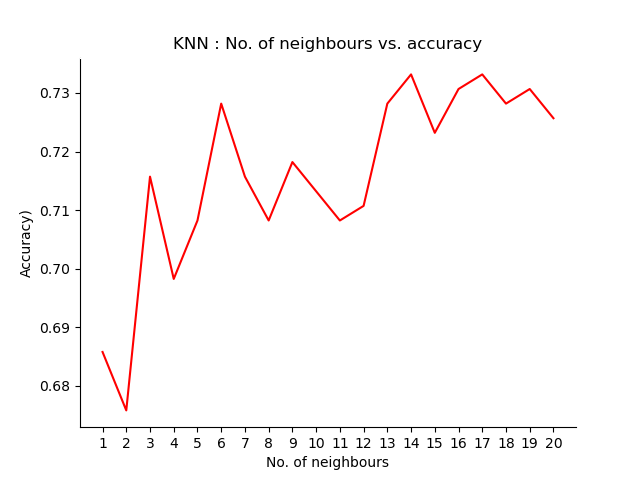

In [19]:
#for KNN I will plot results and choose the optimum number of neighbours
from sklearn.neighbors import KNeighborsClassifier
acc=[1]*20
for n in range (1,21):
    knn_class = KNeighborsClassifier(n_neighbors = n, metric = 'minkowski', p = 2)
    knn_class.fit(X_train_2, y_train)
    y_pred = knn_class.predict(X_test_2)
    acc[n-1]=accuracy_score(y_test,y_pred)

n=list(np.linspace(1,20,20)) 
plt.figure()
plt.plot(n,acc,color='red')

plt.xticks(ticks=list(np.linspace(1,20,20)))
plt.title(f'KNN : No. of neighbours vs. accuracy')
plt.xlabel('No. of neighbours')
plt.ylabel('Accuracy)')

ax=plt.gca() #setting right and top edge as invisible
ax.spines['top'].set_color('white')
ax.spines['right'].set_color('white')

plt.show()

We can see from above theat the highest accuracy is for n=4. 

In [20]:
knn_class = KNeighborsClassifier(n_neighbors = 14, metric = 'minkowski', p = 2)
knn_class.fit(X_train_2, y_train)

y_pred_knn = knn_class.predict(X_test_2)
y_pred_prob_knn=knn_class.predict_proba(X_test_2)[:,1]

#presenting precision-recall results in dataframe
from sklearn.metrics import precision_recall_fscore_support
import warnings
warnings.filterwarnings('ignore')
p, r, f, s = precision_recall_fscore_support(
    y_test,
    y_pred_knn,
    labels=[0,1], # the labels for which we want the metrics determined
    average=None, # when None, returns a metric per label
)
results_knn=pd.DataFrame(data=[p.round(2),r.round(2),f.round(2),s],
                         index=[['Precision','Recall','f score','Support']],
                         columns=[['class 0','class 1']])

For rest of the classifiers I will reppeat the same procedure:
-run cross validation to check on "possible" accuracy
-run GridSearch and cross validation in order to tune hyperparameters.

In [21]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score

sv_class=SVC()

sv_grid=GridSearchCV(estimator=sv_class,
                      param_grid={'C': [1,10,100],'gamma': [0.0001, 0.001,0.01,1],
                                 'kernel':['linear','rbf']},
                     cv=5,verbose=0, n_jobs=-1)
sv_grid.fit(X_train_2,y_train)

sv_grid.best_params_

{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

In [22]:
sv_class = SVC(kernel = 'rbf',C=10, gamma=0.01, random_state = 0,probability=True)
sv_class.fit(X_train_2, y_train)

y_pred_sv=sv_class.predict(X_test_2)
y_pred_prob_sv=sv_class.predict_proba(X_test_2)[:,1]

#presenting precision-recall results in dataframe
from sklearn.metrics import precision_recall_fscore_support
import warnings
warnings.filterwarnings('ignore')
p, r, f, s = precision_recall_fscore_support(
    y_test,
    y_pred_sv,
    labels=[0,1], # the labels for which we want the metrics determined
    average=None, # when None, returns a metric per label
)
results_svc=pd.DataFrame(data=[p.round(2),r.round(2),f.round(2),s],
                         index=[['Precision','Recall','f score','Support']],
                         columns=[['class 0','class 1']])

# Part 4
# Results summary

In [23]:

acc_nb=accuracy_score(y_test,y_pred_nb).round(2)
auc_nb=roc_auc_score(y_test,y_pred_prob_nb).round(2)

acc_log=accuracy_score(y_test,y_pred_log).round(2)
auc_log=roc_auc_score(y_test,y_pred_prob_log).round(2)

acc_knn=accuracy_score(y_test,y_pred_knn).round(2)
auc_knn=roc_auc_score(y_test,y_pred_prob_knn).round(2)

acc_sv=accuracy_score(y_test,y_pred_sv).round(2)
auc_sv=roc_auc_score(y_test,y_pred_prob_sv).round(2)

results1=pd.DataFrame(data=[[acc_nb,auc_nb],[acc_log,auc_log],
                            [acc_knn,auc_knn],[acc_sv,auc_sv]],
                      index=[['Naive Bayes','Logarithmic Regression','KNN',
                            'Support Vector']],columns=[['accuracy','roc-auc']] )

In [24]:
results2=pd.concat([results_nb,results_log,results_knn,results_svc],axis=1,
                    keys=['Naive Bayes','Logarithmic Regression','KNN',
                            'Support Vector'])

In [25]:
results1

,accuracy,roc-auc
Naive Bayes,0.74,0.81
Logarithmic Regression,0.74,0.81
KNN,0.73,0.79
Support Vector,0.73,0.80


In [26]:
results2

Naive Bayes         Logarithmic Regression             KNN          \
              class 0 class 1                class 0 class 1 class 0 class 1   
Precision        0.73    0.75                   0.75    0.74    0.72    0.75   
Recall           0.75    0.73                   0.72    0.76    0.75    0.72   
f score          0.74    0.74                   0.73    0.75    0.73    0.73   
Support        197.00  204.00                 197.00  204.00  197.00  204.00   

          Support Vector          
                 class 0 class 1  
Precision           0.73    0.72  
Recall              0.71    0.75  
f score             0.72    0.73  
Support           197.00  204.00

Looking at accuracy, roc-auc and precision/recall we can agree that the Logarithmic regression and Naive Bayes give the best results. Very close are KNN and SVC while decision trees and regression fortest performed worse in this case. 